# Time Series with Facebook Prophet

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from utils import *
from fbp import ProphetModel

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, dpc_province_df, pop_prov_df, prov_list_df = load_data(data_path)

## Provincial

### New cases

In [5]:
province = "Firenze"
compart = "New_cases"
date = 'Date'
group_column = 'Province'

In [6]:
pm = ProphetModel(data=covidpro_df, 
                  area=province, 
                  compart=compart, 
                  group_column=group_column,
                  date_column=date)

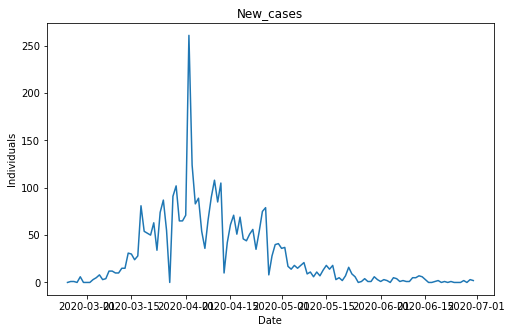

In [7]:
pm.plot_data()

In [8]:
pm.fit()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


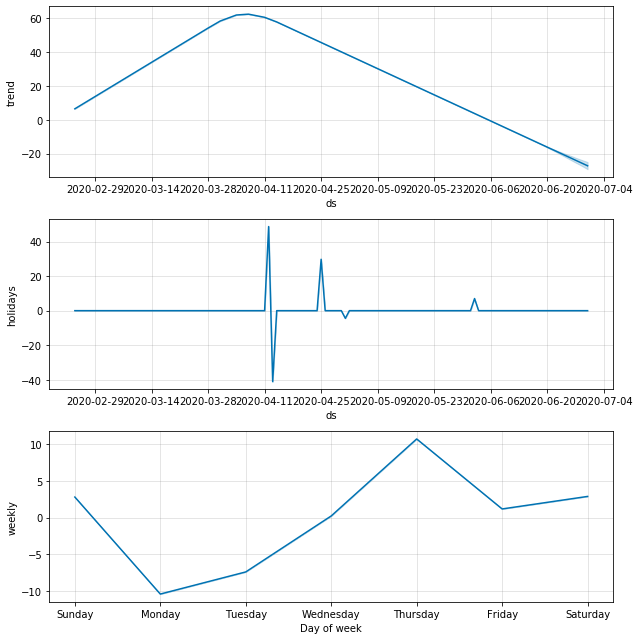

In [9]:
pm.plot_comp()

In [10]:
pm.print_metrics()

MAE: 15.474
MSE: 610.937
RMSE: 24.717


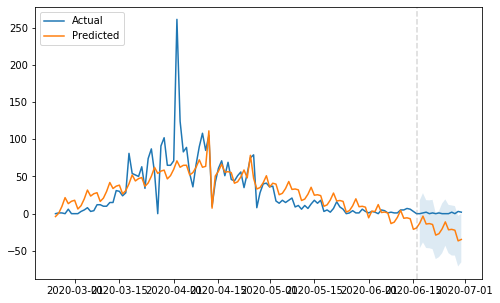

In [11]:
pm.plot()

In [12]:
# Tune the hyperparameters and fit
pm.fit_cv()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5be049cac0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5b942b9a30>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet wit

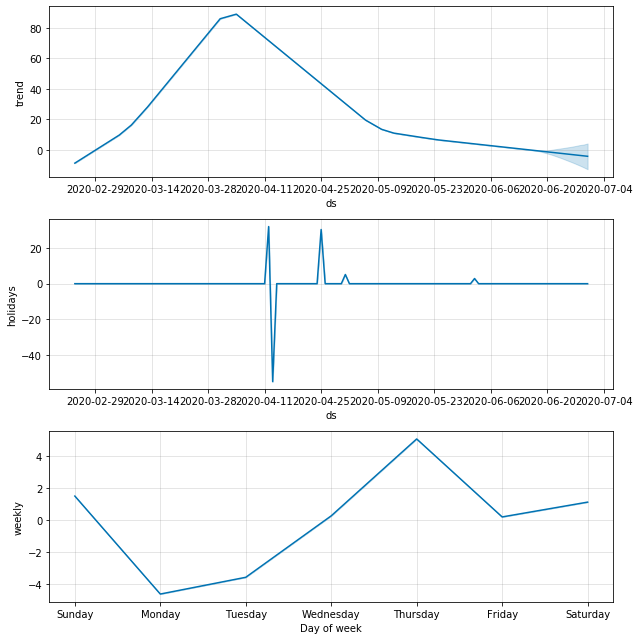

In [13]:
pm.plot_comp()

In [14]:
pm.print_metrics()

MAE: 9.203
MSE: 385.328
RMSE: 19.630


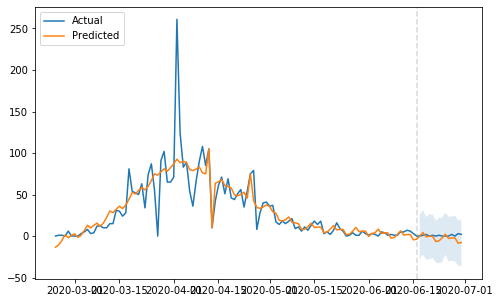

In [15]:
pm.plot()

### Deaths

In [16]:
province = "Firenze"
compart = "Deaths"
date = 'Date'
group_column = 'Province'

In [17]:
pm = ProphetModel(data=covidpro_df, 
                  area=province, 
                  compart=compart, 
                  group_column=group_column,
                  date_column=date)

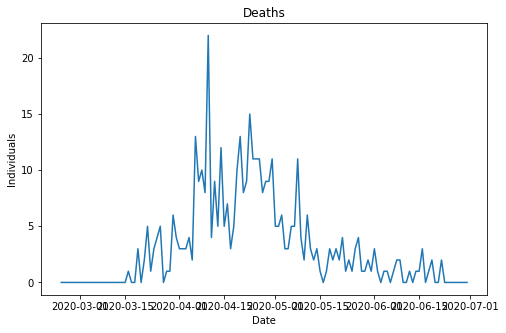

In [18]:
pm.plot_data()

In [19]:
pm.fit_cv()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5b8fc34e80>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5b8fbf51f0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet wit

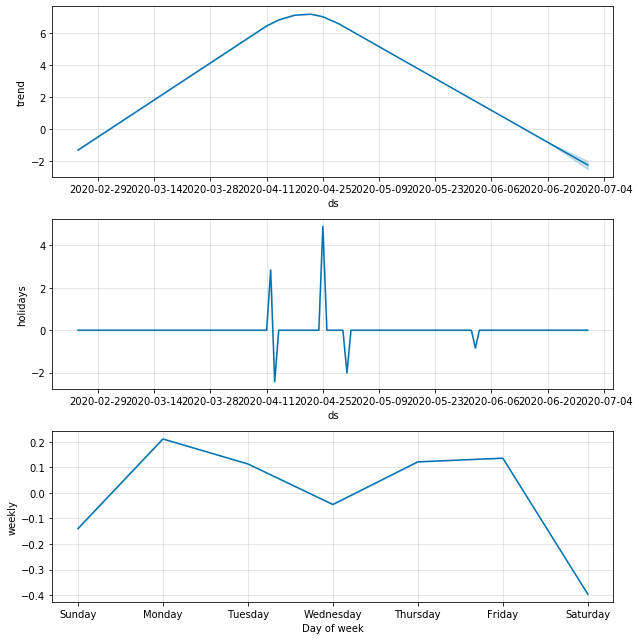

In [20]:
pm.plot_comp()

In [21]:
pm.print_metrics()

MAE: 1.800
MSE: 6.705
RMSE: 2.589


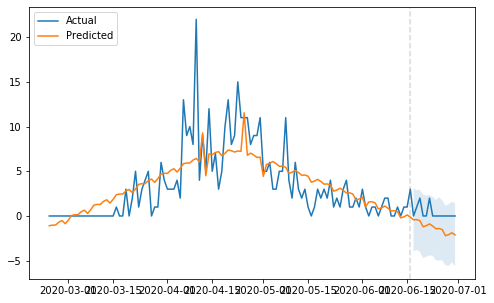

In [22]:
pm.plot()

## Regional

### New cases

In [59]:
province = "Lombardia"
compart = "nuovi_positivi"
date = 'data'
group_column = 'denominazione_regione'

In [60]:
pm = ProphetModel(data=dpc_regioni_df, 
                  area=province, 
                  compart=compart, 
                  group_column=group_column,
                  date_column=date,
                  query='20200701 > data')

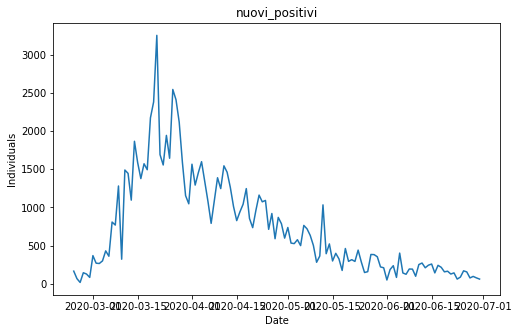

In [61]:
pm.plot_data()

In [62]:
pm.fit_cv()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5bd02f32b0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5bd02f1b80>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet 

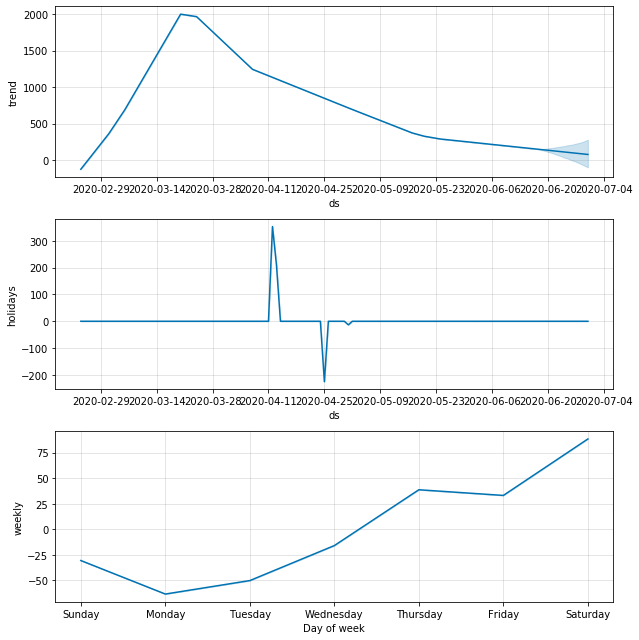

In [63]:
pm.plot_comp()

In [64]:
pm.print_metrics()

MAE: 147.178
MSE: 48905.646
RMSE: 221.146


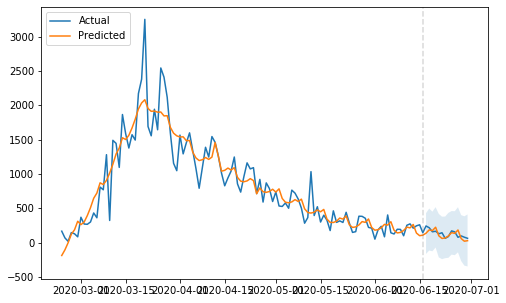

In [65]:
pm.plot()

### Total positives

In [85]:
province = "Lombardia"
compart = "totale_positivi"
date = 'data'
group_column = 'denominazione_regione'

In [86]:
pm = ProphetModel(data=dpc_regioni_df, 
                  area=province, 
                  compart=compart, 
                  group_column=group_column,
                  date_column=date,
                  query='20200701 > data')

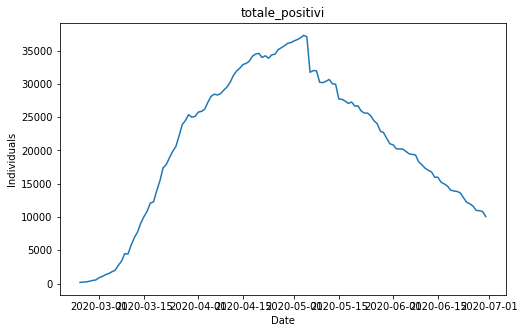

In [87]:
pm.plot_data()

In [88]:
pm.fit_cv()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5b8ca8ae80>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5b8cb9f610>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet 

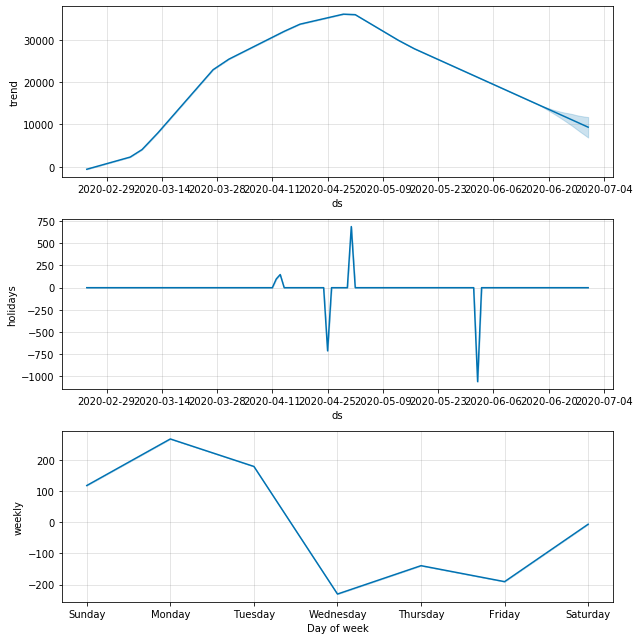

In [89]:
pm.plot_comp()

In [90]:
pm.print_metrics()

MAE: 445.890
MSE: 380196.095
RMSE: 616.600


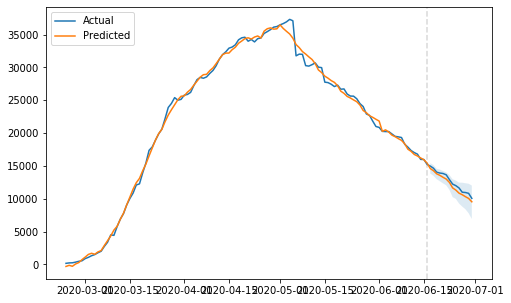

In [91]:
pm.plot()

No holidays

In [92]:
pm = ProphetModel(data=dpc_regioni_df, 
                  area=province, 
                  compart=compart, 
                  group_column=group_column,
                  date_column=date,
                  query='20200701 > data',
                  holidays=False)

In [93]:
pm.fit_cv()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5b8ce8a4c0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5be0432d60>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet 

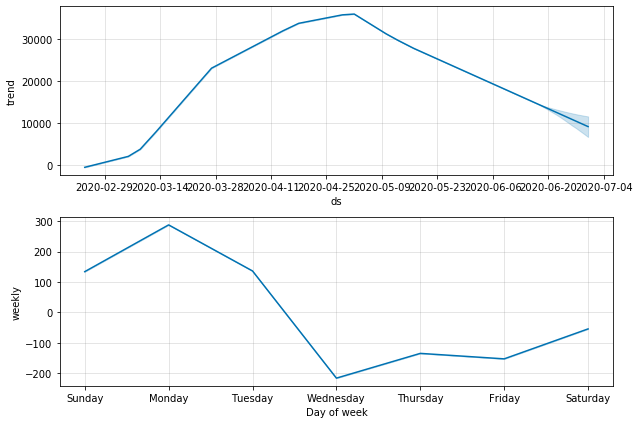

In [94]:
pm.plot_comp()

In [95]:
pm.print_metrics()

MAE: 452.710
MSE: 377373.687
RMSE: 614.307


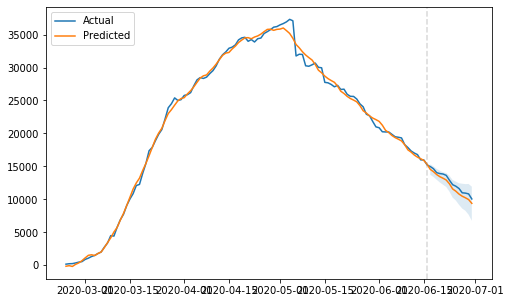

In [96]:
pm.plot()

### Total cases

In [7]:
province = "Lombardia"
compart = "totale_casi"
date = 'data'
group_column = 'denominazione_regione'

In [98]:
pm = ProphetModel(data=dpc_regioni_df, 
                  area=province, 
                  compart=compart, 
                  group_column=group_column,
                  date_column=date,
                  query='20200701 > data')

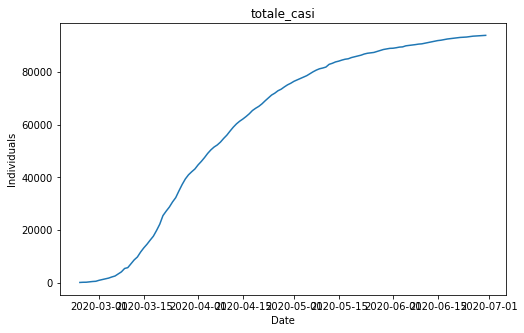

In [99]:
pm.plot_data()

In [100]:
pm.fit_cv()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5b8ce8a8e0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5b8cc458e0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet 

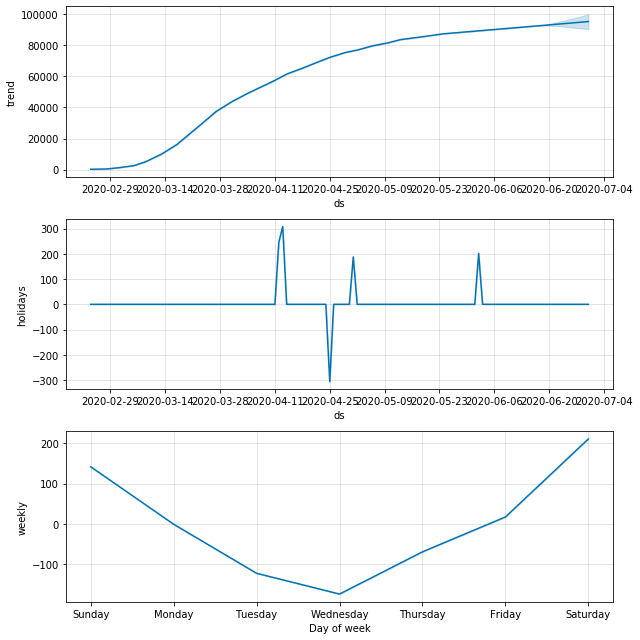

In [101]:
pm.plot_comp()

In [102]:
pm.print_metrics()

MAE: 168.861
MSE: 68384.522
RMSE: 261.504


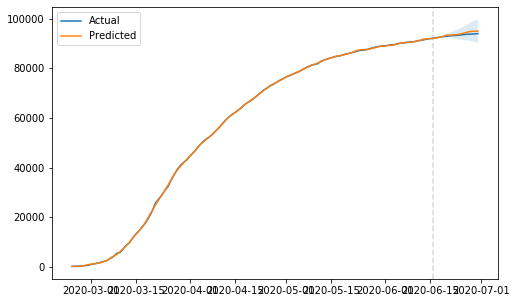

In [103]:
pm.plot()

### Total cases
Logistic growth

In [ ]:
province = "Lombardia"
compart = "totale_casi"
date = 'data'
group_column = 'denominazione_regione'

In [8]:
pm = ProphetModel(data=dpc_regioni_df, 
                  area=province, 
                  compart=compart, 
                  group_column=group_column,
                  date_column=date,
                  query='20200701 > data',
                  growth='logistic',
                  holidays=True)

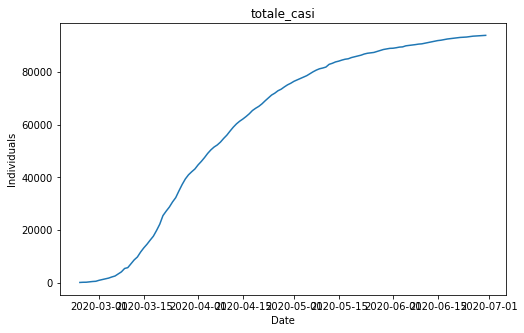

In [9]:
pm.plot_data()

In [10]:
pm.fit_cv()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb639d5aca0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb63924d940>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet 

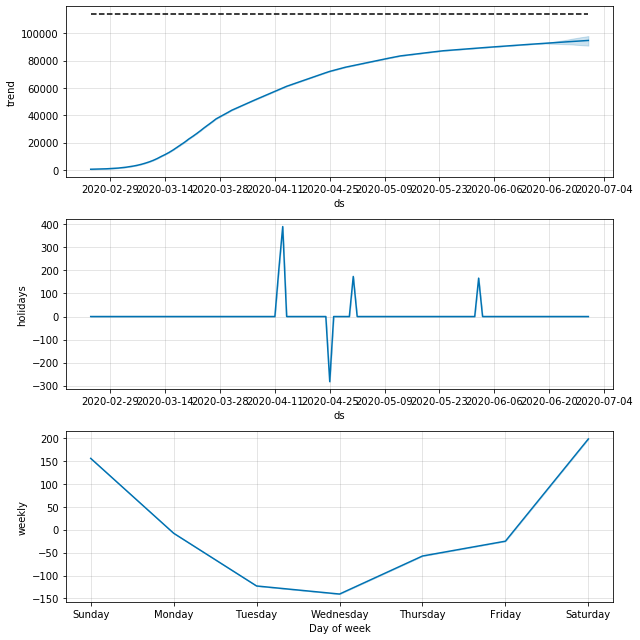

In [11]:
pm.plot_comp()

In [12]:
pm.print_metrics()

MAE: 183.144
MSE: 59699.977
RMSE: 244.336


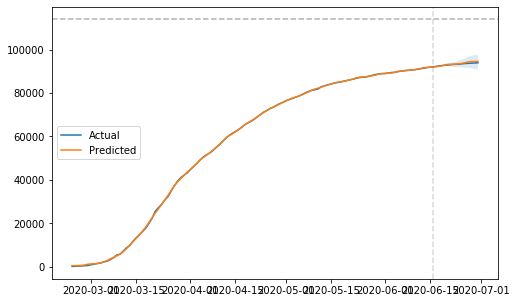

In [13]:
pm.plot()